In [ ]:
'''
Adaptation of the Hilbert CNN at https://openreview.net/forum?id=HJvvRoe0W
Works by encoding each nucleotide as a one-hot vector, 
then fits it to a image-like grid using a hilbert curve
such that each 'pixel' is a 1mer of length 4
'''

In [1]:
from keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Dense, Dropout, SeparableConv2D, Add
from keras.layers import Activation, Input, Concatenate, Flatten, MaxPooling2D, Reshape, GaussianNoise
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, LearningRateScheduler
import image
from keras import backend as K
import numpy as np

c:\users\wolfgang\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
start_target_size = (32, 32, 4)
batch_size = 16
train_path = 'D:/Projects/iSynPro/iSynPro/HilbertCNN/train_val_npys/6count/1mer/train'
test_path = 'D:/Projects/iSynPro/iSynPro/HilbertCNN/train_val_npys/6count/1mer/test'

# define generators
train_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

train_generator = train_datagen.flow_np_from_directory(train_path, 
                                                    target_size= start_target_size, 
                                                    batch_size=batch_size, 
                                                    class_mode='binary',
                                                    seed=42) 

validation_generator = test_datagen.flow_np_from_directory(test_path, 
                                                        target_size= start_target_size, 
                                                        batch_size=batch_size, 
                                                        class_mode='binary',
                                                        seed=42)

Found 17588 images belonging to 2 classes.
Found 1955 images belonging to 2 classes.


In [11]:
K.clear_session()
del model

In [24]:
# original implementation of Hilbert-CNN
# https://openreview.net/forum?id=HJvvRoe0W

def computation_block(in_layer, n_filters, filtersize_a, filtersize_b, filtersize_c, filtersize_d):

    # residual 1
    p1 = Conv2D(n_filters, (filtersize_a, filtersize_a), strides=(1, 1), padding='same')(in_layer)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p1 = Conv2D(n_filters, (filtersize_b, filtersize_b), strides=(1, 1), padding='same')(p1)
    p1 = BatchNormalization()(p1)

    # residual 2
    p2 = Conv2D(n_filters, (filtersize_c, filtersize_c), strides=(1, 1), padding='same')(in_layer)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n_filters, (filtersize_d, filtersize_d), strides=(1, 1), padding='same')(p2)
    p2 = BatchNormalization()(p2)

    x = Concatenate()([in_layer, p1, p2])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# stem
inputs = Input(shape=[32, 32, 4])
x = GaussianNoise(0.2)(inputs)
x = Conv2D(64, (7, 7), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = computation_block(x, 4, 8, 4, 4, 3)
x = computation_block(x, 4, 3, 3, 3, 3)
# mid-stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = computation_block(x, 4, 2, 4, 4, 3)
x = computation_block(x, 4, 2, 2, 2, 2)
x = computation_block(x, 4, 3, 2, 2, 3)


# exit stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x) #we omit this last avgpool to retain dimensionality
x = Flatten()(x)

# FC layers
x = Dense(1024, activation='relu')(x)

x = Dense(1024, activation='relu')(x)
#x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer= SGD(lr= 0.01, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
gaussian_noise_9 (GaussianNoise (None, 32, 32, 4)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 32, 32, 64)   12608       gaussian_noise_9[0][0]           
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 32, 32, 64)   256         conv2d_177[0][0]                 
__________________________________________________________________________________________________
conv2d_178

In [27]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
lr_descent = ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.5,
                                               patience=5,
                                               verbose=1,
                                               mode='auto',
                                               epsilon=0.0001,
                                               cooldown=1,
                                               min_lr=0)

root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/vanilla_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)

#tracking = keras.callbacks.ProgbarLogger(count_mode='samples')

#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.53822, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/vanilla_hilbertcnn/weights-01-0.54.hdf5
 - 48s - loss: 0.5807 - binary_accuracy: 0.6855 - val_loss: 0.5382 - val_binary_accuracy: 0.7339
Epoch 2/30

Epoch 00002: val_loss did not improve
 - 35s - loss: 0.5468 - binary_accuracy: 0.7177 - val_loss: 0.5489 - val_binary_accuracy: 0.7091
Epoch 3/30

Epoch 00003: val_loss improved from 0.53822 to 0.53342, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/vanilla_hilbertcnn/weights-03-0.53.hdf5
 - 35s - loss: 0.5308 - binary_accuracy: 0.7234 - val_loss: 0.5334 - val_binary_accuracy: 0.7081
Epoch 4/30

Epoch 00004: val_loss improved from 0.53342 to 0.53088, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/vanilla_hilbertcnn/weights-04-0.53.hdf5
 - 36s - loss: 0.5225 - binary_accuracy: 0.7317 - val_loss: 0.5309 - val_binary_accuracy: 0.7091
Epoch 5/30


In [14]:
# Modified version of Hilbert-CNN
# batchnorm after activation

def computation_block(in_layer, n_filters, filtersize_a, filtersize_b, filtersize_c, filtersize_d):

    # residual 1
    p1 = Conv2D(n_filters, (filtersize_a, filtersize_a), strides=(1, 1), padding='same', activation='relu')(in_layer)
    p1 = BatchNormalization()(p1)
    p1 = Conv2D(n_filters, (filtersize_b, filtersize_b), strides=(1, 1), padding='same', activation='relu')(p1)
    p1 = BatchNormalization()(p1)

    # residual 2
    p2 = Conv2D(n_filters, (filtersize_c, filtersize_c), strides=(1, 1), padding='same', activation='relu')(in_layer)
    p2 = BatchNormalization()(p2)
    p2 = Conv2D(n_filters, (filtersize_d, filtersize_d), strides=(1, 1), padding='same', activation='relu')(p2)
    p2 = BatchNormalization()(p2)

    x = Concatenate()([in_layer, p1, p2])
    #x = Activation('relu')(x)
    #x = BatchNormalization()(x)
    return x

# stem
inputs = Input(shape=[32, 32, 4])
x = GaussianNoise(0.3)(inputs)
x = Conv2D(64, (7, 7), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = computation_block(x, 4, 8, 4, 4, 3)
x = computation_block(x, 4, 3, 3, 3, 3)
# mid-stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = computation_block(x, 4, 2, 4, 4, 3)
x = computation_block(x, 4, 2, 2, 2, 2)
x = computation_block(x, 4, 3, 2, 2, 3)


# exit stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) #we omit this last avgpool to retain dimensionality
x = Flatten()(x)

# FC layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer= SGD(lr= 1e-2, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])

In [15]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)


#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.73496, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_hilbertcnn/weights-01-0.73.hdf5
 - 404s - loss: 0.6319 - binary_accuracy: 0.6322 - val_loss: 0.7350 - val_binary_accuracy: 0.5881
Epoch 2/30

Epoch 00002: val_loss improved from 0.73496 to 0.59861, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_hilbertcnn/weights-02-0.60.hdf5
 - 32s - loss: 0.5682 - binary_accuracy: 0.6992 - val_loss: 0.5986 - val_binary_accuracy: 0.6674
Epoch 3/30

Epoch 00003: val_loss improved from 0.59861 to 0.58810, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_hilbertcnn/weights-03-0.59.hdf5
 - 32s - loss: 0.5492 - binary_accuracy: 0.7133 - val_loss: 0.5881 - val_binary_accuracy: 0.7081
Epoch 4/30

Epoch 00004: val_loss improved from 0.58810 to 0.52329, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 32, 32, 4)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   12608       gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
# Modified version of Hilbert-CNN
# batchnorm after activation

def computation_block(in_layer, n_filters, filtersize_a, filtersize_b, filtersize_c, filtersize_d):

    # residual 1
    p1 = Conv2D(n_filters, (filtersize_a, filtersize_a), strides=(1, 1), padding='same', activation='relu')(in_layer)
    p1 = BatchNormalization()(p1)
    p1 = Conv2D(n_filters, (filtersize_b, filtersize_b), strides=(1, 1), padding='same')(p1)
    #p1 = BatchNormalization()(p1)

    # residual 2
    p2 = Conv2D(n_filters, (filtersize_c, filtersize_c), strides=(1, 1), padding='same', activation='relu')(in_layer)
    p2 = BatchNormalization()(p2)
    p2 = Conv2D(n_filters, (filtersize_d, filtersize_d), strides=(1, 1), padding='same')(p2)
    #p2 = BatchNormalization()(p2)

    x = Concatenate()([in_layer, p1, p2])
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    return x

# stem
inputs = Input(shape=[32, 32, 4])
x = GaussianNoise(0.3)(inputs)
x = Conv2D(64, (7, 7), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = computation_block(x, 4, 8, 4, 4, 3)
x = computation_block(x, 4, 3, 3, 3, 3)
# mid-stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = computation_block(x, 4, 2, 4, 4, 3)
x = computation_block(x, 4, 2, 2, 2, 2)
x = computation_block(x, 4, 3, 2, 2, 3)


# exit stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) #we omit this last avgpool to retain dimensionality
x = Flatten()(x)

# FC layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer= SGD(lr= 1e-2, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])

In [17]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_close_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)


#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.59563, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_close_hilbertcnn/weights-01-0.60.hdf5
 - 38s - loss: 0.6171 - binary_accuracy: 0.6597 - val_loss: 0.5956 - val_binary_accuracy: 0.6973
Epoch 2/30

Epoch 00002: val_loss improved from 0.59563 to 0.53943, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_close_hilbertcnn/weights-02-0.54.hdf5
 - 31s - loss: 0.5720 - binary_accuracy: 0.6952 - val_loss: 0.5394 - val_binary_accuracy: 0.7241
Epoch 3/30

Epoch 00003: val_loss did not improve
 - 30s - loss: 0.5519 - binary_accuracy: 0.7106 - val_loss: 0.6027 - val_binary_accuracy: 0.6906
Epoch 4/30

Epoch 00004: val_loss improved from 0.53943 to 0.51902, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_close_hilbertcnn/weights-04-0.52.hdf5
 - 31s - loss: 0.5408 - binary_accuracy: 0.7163 - val_loss: 0.5190 - val_binary_accurac

In [22]:
# Modified version of Hilbert-CNN
# batchnorm after activation
# wide network
# Max pooling

def computation_block(in_layer, n_filters, filtersize_a, filtersize_b, filtersize_c, filtersize_d):

    # residual 1
    p1 = Conv2D(n_filters, (filtersize_a, filtersize_a), strides=(1, 1), padding='same', activation='relu')(in_layer)
    p1 = BatchNormalization()(p1)
    p1 = Conv2D(n_filters, (filtersize_b, filtersize_b), strides=(1, 1), padding='same')(p1)
    #p1 = BatchNormalization()(p1)

    # residual 2
    p2 = Conv2D(n_filters, (filtersize_c, filtersize_c), strides=(1, 1), padding='same', activation='relu')(in_layer)
    p2 = BatchNormalization()(p2)
    p2 = Conv2D(n_filters, (filtersize_d, filtersize_d), strides=(1, 1), padding='same')(p2)
    #p2 = BatchNormalization()(p2)

    x = Concatenate()([in_layer, p1, p2])
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    return x

# stem
inputs = Input(shape=[32, 32, 4])
x = GaussianNoise(0.3)(inputs)
x = Conv2D(256, (7, 7), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = computation_block(x, 32, 8, 4, 4, 3)
x = computation_block(x, 32, 3, 3, 3, 3)
# mid-stem
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = computation_block(x, 32, 2, 4, 4, 3)
x = computation_block(x, 32, 2, 2, 2, 2)
x = computation_block(x, 32, 3, 2, 2, 3)


# exit stem
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Flatten()(x)

# FC layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer= SGD(lr= 1e-2, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])

In [23]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_wide_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)


#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.65489, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_wide_hilbertcnn/weights-01-0.65.hdf5
 - 126s - loss: 0.6923 - binary_accuracy: 0.6381 - val_loss: 0.6549 - val_binary_accuracy: 0.6859
Epoch 2/30

Epoch 00002: val_loss improved from 0.65489 to 0.56805, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_wide_hilbertcnn/weights-02-0.57.hdf5
 - 117s - loss: 0.5759 - binary_accuracy: 0.6970 - val_loss: 0.5681 - val_binary_accuracy: 0.7256
Epoch 3/30

Epoch 00003: val_loss did not improve
 - 116s - loss: 0.5597 - binary_accuracy: 0.6994 - val_loss: 0.5941 - val_binary_accuracy: 0.6983
Epoch 4/30

Epoch 00004: val_loss improved from 0.56805 to 0.55098, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/modified_wide_hilbertcnn/weights-04-0.55.hdf5
 - 117s - loss: 0.5463 - binary_accuracy: 0.7127 - val_loss: 0.5510 - val_binary_accura

KeyboardInterrupt: 

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
gaussian_noise_7 (GaussianNoise (None, 32, 32, 4)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 32, 32, 256)  50432       gaussian_noise_7[0][0]           
__________________________________________________________________________________________________
batch_normalization_129 (BatchN (None, 32, 32, 256)  1024        conv2d_133[0][0]                 
__________________________________________________________________________________________________
conv2d_134

In [31]:
# original implementation of Hilbert-CNN
# https://openreview.net/forum?id=HJvvRoe0W
# no dimension reduction before dense 

def computation_block(in_layer, n_filters, filtersize_a, filtersize_b, filtersize_c, filtersize_d):

    # residual 1
    p1 = Conv2D(n_filters, (filtersize_a, filtersize_a), strides=(1, 1), padding='same')(in_layer)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p1 = Conv2D(n_filters, (filtersize_b, filtersize_b), strides=(1, 1), padding='same')(p1)
    p1 = BatchNormalization()(p1)

    # residual 2
    p2 = Conv2D(n_filters, (filtersize_c, filtersize_c), strides=(1, 1), padding='same')(in_layer)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n_filters, (filtersize_d, filtersize_d), strides=(1, 1), padding='same')(p2)
    p2 = BatchNormalization()(p2)

    x = Concatenate()([in_layer, p1, p2])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# stem
inputs = Input(shape=[32, 32, 4])
x = GaussianNoise(0.2)(inputs)
x = Conv2D(64, (7, 7), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = computation_block(x, 4, 8, 4, 4, 3)
x = computation_block(x, 4, 3, 3, 3, 3)
# mid-stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = computation_block(x, 4, 2, 4, 4, 3)
x = computation_block(x, 4, 2, 2, 2, 2)
x = computation_block(x, 4, 3, 2, 2, 3)


# exit stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x) #we omit this last avgpool to retain dimensionality
x = Flatten()(x)

# FC layers
x = Dense(1024, activation='relu')(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer= SGD(lr= 0.01, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])

In [32]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/highdimdropout_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)


#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.55333, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/highdimdropout_hilbertcnn/weights-01-0.55.hdf5
 - 53s - loss: 0.5959 - binary_accuracy: 0.6777 - val_loss: 0.5533 - val_binary_accuracy: 0.7158
Epoch 2/30

Epoch 00002: val_loss did not improve
 - 36s - loss: 0.5549 - binary_accuracy: 0.7085 - val_loss: 0.6000 - val_binary_accuracy: 0.6787
Epoch 3/30

Epoch 00003: val_loss improved from 0.55333 to 0.52281, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/highdimdropout_hilbertcnn/weights-03-0.52.hdf5
 - 36s - loss: 0.5368 - binary_accuracy: 0.7241 - val_loss: 0.5228 - val_binary_accuracy: 0.7463
Epoch 4/30

Epoch 00004: val_loss did not improve
 - 36s - loss: 0.5326 - binary_accuracy: 0.7259 - val_loss: 0.5369 - val_binary_accuracy: 0.7179
Epoch 5/30

Epoch 00005: val_loss improved from 0.52281 to 0.51251, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/

KeyboardInterrupt: 

In [33]:
# original implementation of Hilbert-CNN
# https://openreview.net/forum?id=HJvvRoe0W
# has averagepooling2D before dense

def computation_block(in_layer, n_filters, filtersize_a, filtersize_b, filtersize_c, filtersize_d):

    # residual 1
    p1 = Conv2D(n_filters, (filtersize_a, filtersize_a), strides=(1, 1), padding='same')(in_layer)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p1 = Conv2D(n_filters, (filtersize_b, filtersize_b), strides=(1, 1), padding='same')(p1)
    p1 = BatchNormalization()(p1)

    # residual 2
    p2 = Conv2D(n_filters, (filtersize_c, filtersize_c), strides=(1, 1), padding='same')(in_layer)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n_filters, (filtersize_d, filtersize_d), strides=(1, 1), padding='same')(p2)
    p2 = BatchNormalization()(p2)

    x = Concatenate()([in_layer, p1, p2])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# stem
inputs = Input(shape=[32, 32, 4])
x = GaussianNoise(0.2)(inputs)
x = Conv2D(64, (7, 7), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = computation_block(x, 4, 8, 4, 4, 3)
x = computation_block(x, 4, 3, 3, 3, 3)
# mid-stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = computation_block(x, 4, 2, 4, 4, 3)
x = computation_block(x, 4, 2, 2, 2, 2)
x = computation_block(x, 4, 3, 2, 2, 3)


# exit stem
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
x = Flatten()(x)

# FC layers
x = Dense(1024, activation='relu')(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer= SGD(lr= 0.01, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])

In [34]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/lowdimdropout_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)


#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.54871, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/lowdimdropout_hilbertcnn/weights-01-0.55.hdf5
 - 55s - loss: 0.5959 - binary_accuracy: 0.6698 - val_loss: 0.5487 - val_binary_accuracy: 0.7133
Epoch 2/30

Epoch 00002: val_loss did not improve
 - 36s - loss: 0.5505 - binary_accuracy: 0.7138 - val_loss: 0.5928 - val_binary_accuracy: 0.6699
Epoch 3/30

Epoch 00003: val_loss did not improve
 - 36s - loss: 0.5381 - binary_accuracy: 0.7192 - val_loss: 0.5581 - val_binary_accuracy: 0.6978
Epoch 4/30

Epoch 00004: val_loss improved from 0.54871 to 0.53085, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/lowdimdropout_hilbertcnn/weights-04-0.53.hdf5
 - 36s - loss: 0.5316 - binary_accuracy: 0.7247 - val_loss: 0.5309 - val_binary_accuracy: 0.7153
Epoch 5/30

Epoch 00005: val_loss did not improve
 - 36s - loss: 0.5239 - binary_accuracy: 0.7333 - val_loss: 0.5351 - val_binary_accu

In [6]:
from keras.applications.mobilenet import MobileNet
from keras.applications import mobilenet

In [13]:
# truncated mobilenet

head_model = MobileNet(include_top=False,
                       weights=None,
                       input_shape = (32, 32, 4))

x = head_model.get_layer('conv_pw_2_relu').output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.8)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=head_model.input, outputs=predictions)
model.compile(optimizer= SGD(lr= 0.01, momentum=0.9),
              loss= 'binary_crossentropy',
              metrics=[ 'binary_accuracy'])
model.summary()

c:\users\wolfgang\anaconda3\envs\tensorflow\lib\site-packages\keras\applications\imagenet_utils.py:257: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        1152      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 16, 16, 32)        0         
__________

In [14]:
train_size = 17588
test_size = 1955
learning_rate = 1e-3
learning_decay = 0.94
batch_size = 16


#our callbacks
root_path = 'D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/mobile_hilbertcnn'
save_model = ModelCheckpoint(root_path + '/weights-{epoch:02d}-{val_loss:.2f}.hdf5',
                                             monitor='val_loss',
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto',
                                             period=1)

csv_path = '{}/training_history.csv'.format(root_path)
csv_logger = CSVLogger(csv_path, separator=',', append=False)

def incep_resnet_schedule(epoch):
    if epoch % 2 == 0:
        return learning_rate*(learning_decay**(epoch))
    else:
        return learning_rate*(learning_decay**((epoch)-1.0))

lr_scheduler = LearningRateScheduler(incep_resnet_schedule)


#train the model
model.fit_generator(train_generator,
                    steps_per_epoch= train_size // batch_size,
                    epochs=30,
                    validation_data= validation_generator,
                    validation_steps= test_size // batch_size,
                    verbose=2,
                    callbacks = [save_model, csv_logger, lr_scheduler])

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.55217, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/mobile_hilbertcnn/weights-01-0.55.hdf5
 - 25s - loss: 0.6268 - binary_accuracy: 0.6661 - val_loss: 0.5522 - val_binary_accuracy: 0.7009
Epoch 2/30

Epoch 00002: val_loss improved from 0.55217 to 0.51647, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/mobile_hilbertcnn/weights-02-0.52.hdf5
 - 21s - loss: 0.5575 - binary_accuracy: 0.7048 - val_loss: 0.5165 - val_binary_accuracy: 0.7127
Epoch 3/30

Epoch 00003: val_loss did not improve
 - 18s - loss: 0.5413 - binary_accuracy: 0.7157 - val_loss: 0.5225 - val_binary_accuracy: 0.7127
Epoch 4/30

Epoch 00004: val_loss improved from 0.51647 to 0.50570, saving model to D:/Projects/Github/SyntheticPromoter/HilbertCNN/weights/1mer/mobile_hilbertcnn/weights-04-0.51.hdf5
 - 19s - loss: 0.5272 - binary_accuracy: 0.7214 - val_loss: 0.5057 - val_binary_accuracy: 0.7303
Epoch 5/30

Ep

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import os
import keras.applications.mobilenet
from keras.utils.generic_utils import CustomObjectScope


In [3]:
high_path = 'D:/Projects/iSynPro/iSynPro/HilbertCNN/train_val_npys/6count/1mer/test/high'
low_path = 'D:/Projects/iSynPro/iSynPro/HilbertCNN/train_val_npys/6count/1mer/test/low'

high_xcomp = []
high_ycomp = []
for root, subdir, files in os.walk(high_path):
    for file in files:
        high_xcomp.append(np.load(os.path.join(root, file)))
        high_ycomp.append(0)

low_xcomp = []
low_ycomp = []
for root, subdir, files in os.walk(low_path):
    for file in files:
        low_xcomp.append(np.load(os.path.join(root, file)))
        low_ycomp.append(1)
    
x_test = np.asarray(low_xcomp + high_xcomp)
y_test = np.asarray(low_ycomp + high_ycomp)

In [11]:
model_list = ['D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/vanilla_hilbertcnn/weights-18-0.50.hdf5',
              'D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/modified_hilbertcnn/weights-16-0.50.hdf5',
              'D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/modified_close_hilbertcnn/weights-07-0.50.hdf5',
              'D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/modified_wide_hilbertcnn/weights-04-0.55.hdf5',
              'D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/highdimdropout_hilbertcnn/weights-09-0.49.hdf5',
              'D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/lowdimdropout_hilbertcnn/weights-19-0.49.hdf5',
              'D:/Projects/iSynPro/SyntheticPromoter/HilbertCNN/weights/1mer/mobile_hilbertcnn/weights-13-0.48.hdf5'
             ]
label_list = ['Vanilla Hilbert-CNN',
              'Batchnorm -BlockRelu +FinalRelu',
              'Batchnorm +BlockRelu -FinalRelu',
              'Wide Hilbert-CNN',
              'Hilbert-CNN -FinalMaxPool +Dropout',
              'Hilbert-CNN +FinalMaxPool +Dropout',
              'MobileNet truncated']
roc_list = []
for path in model_list:
    with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
        model = load_model(path)
        y_pred = model.predict(x_test)
        auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_list.append([fpr, tpr, auc])

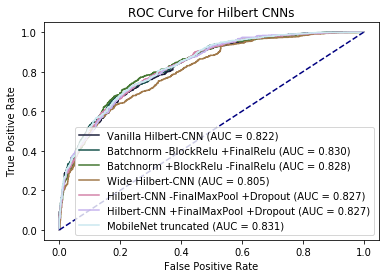

In [12]:
palette = sns.color_palette("cubehelix", len(roc_list))

#plot roc curve
for i in range(len(roc_list)):
    plt.plot(roc_list[i][0], 
             roc_list[i][1], 
             color=palette[i], 
             label='{0} (AUC = {1:.3f})'.format(label_list[i], roc_list[i][2]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hilbert CNNs')
plt.legend(loc="lower right")
plt.savefig('d:/projects/isynpro/SyntheticPromoter/readme_figures/hilbert_roc.png', bbox_inches = 'tight')
plt.show()